In [166]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
%matplotlib inline

In [167]:
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split
from nltk import word_tokenize,sent_tokenize
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.71274503103825837, 'present': 0.70142321085794701}


In [169]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 45.1792621676
Component 0:
" Oh !     0.99929
" Oh !"    0.99929
" Oh !     0.99929
" Oh !"    0.99929
" Oh !     0.99929
" Oh !"    0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

CHAPTER X      0.998943
CHAPTER V      0.998943
CHAPTER I      0.998943
CHAPTER I      0.998943
CHAPTER V      0.998943
CHAPTER I      0.998943
CHAPTER V      0.998943
CHAPTER X      0.998943
CHAPTER X      0.998943
CHAPTER XII    0.998074
Name: 2, dtype: float64
Component 3:
" Ah !      0.992899
" Ah !      0.992899
But ah !    0.992899
" Ah !      0.992899
" Ah !      0.992899
" Ah !      0.992899
" Ah !      0.992899
" Ah !      0.992899
" Ah !"     0.992899
But ah !    0.992899
Name: 3, dtype: float64
Component 4:
" There were misunderstandings between them , Emma ; he said so expressly .    0.650564
Emma demurred .                                                                0.598345
" Are you well , my Emma ?"                                                    0.598345
Emma was silenced .                                                            0.586730
At first it was downright dulness to Emma .                                    0.585489
" Emma , my dear Emma "             

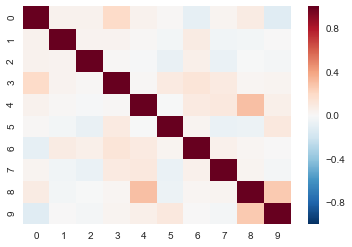

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [170]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


In [171]:
#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Component 0:
" Oh !       0.999918
" Oh no !    0.999918
" Oh no !    0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.613064
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                                                                  

Yes, it does find similar sentences for components 0 through 4 such as "Oh!" and when Emma is speaking.

# Challenge 1

In [172]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(10000)]

def bag_of_names(doc):
    
    names = [ent.text for ent in doc.ents]
    return [item[0] for item in Counter(names).most_common(200)]

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0

    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df


In [173]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [174]:
nlp = spacy.load('en')
emma2 = gutenberg.raw('austen-emma.txt')
emma2 = text_cleaner(emma2)
emma_doc = nlp(emma2)
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]
emma_sentences = pd.DataFrame(emma_sents)
common_words = bag_of_words(emma_doc)
common_names = bag_of_names(emma_doc)
emma_bow = bow_features(emma_sentences, common_words)
#splitting into training and test sets
X_train2, X_test2 = train_test_split(emma_bow, test_size=0.4)
X_train2 = X_train2.drop(['text_source', 'text_sentence'], axis=1)
X_test2 = X_test2.drop(['text_source', 'text_sentence'], axis=1)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500


In [175]:
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train2_lsa = lsa.fit_transform(X_train2)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 50.2122490615


In [176]:
common_names = bag_of_names(emma_doc)
emma_bon = bow_features(emma_sentences, common_names)
#splitting into training and test sets
X_train3, X_test3 = train_test_split(emma_bon, test_size=0.4)
X_train3 = X_train3.drop(['text_source', 'text_sentence'], axis=1)
X_test3 = X_test3.drop(['text_source', 'text_sentence'], axis=1)

svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train3_lsa = lsa.fit_transform(X_train3)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
     Emma Weston Elton Harriet Knightley first Jane Woodhouse one Hartfield  \
545     0      0     0       0         0     0    0         0   0         0   
1074    0      0     0       0         0     0    0         0   0         0   
7935    0      0     0       0         0     0    0         0   0         0   
311     0      0     0       0         0     0    0         0   0         0   
6704    0      0     0       0         0     0    0         0   0         0   
8583    0      0     0       0         0     0    0         0   0         0   
796     0      0     0       0         0     0    0         0   0         0   
6903    0   

Percent variance captured by all components: 100.0
